In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

In [59]:
# Inventory Data
inventory_df = pd.read_json('./data/exported_listings.json')
stock_df = pd.read_json('./data/stock_listing_v2_1.json')
inventory_df = inventory_df.merge(stock_df, on='_id')
inventory_df = inventory_df[['date', 'title', 'category', 'unit_cost', 'current_stock', 'avg_usage_per_day']]
inventory_df.sort_values('date', inplace=True)

# ABC Model Cluster Results Data
abc_clusters_df = pd.read_csv('./data/abc_clusters.csv')

In [60]:
inventory_df

,date,title,category,unit_cost,current_stock,avg_usage_per_day
0,2022-01-01,Ventilator,Equipment,2628329,22,5
2080,2022-01-01,Defibrilator,Equipment,650745,6,0
3121,2022-01-01,Wheelchair,Equipment,15486,23,0
5177,2022-01-01,ECG Machine,Equipment,314121,2,2
6211,2022-01-01,MRI Scanner,Equipment,40522506,1,1
...,...,...,...,...,...,...
14487,2024-12-31,Syringe,Consumable,20,5990,680
1023,2024-12-31,Ventilator,Equipment,1852964,22,1
15536,2024-12-31,Bandages,Consumable,11,3405,430
9310,2024-12-31,Gloves,Consumable,13,4101,708


In [61]:
abc_clusters_df

,title,year,month,category,unit_cost,beginning_inventory,ending_inventory,annual_usage_value,monthly_usage,annual_usage,stock_turnover_rate,stock_variability,cluster,ABC_category
0,Antiseptic Solution,2022,2022-01,Consumable,4.554325e+02,958,2474,4.591761e+07,8401.833333,100822,4.896173,0.504353,0,C
1,Antiseptic Solution,2022,2022-02,Consumable,4.554325e+02,2762,2992,4.591761e+07,8401.833333,100822,2.920345,0.504353,0,C
2,Antiseptic Solution,2022,2022-03,Consumable,4.554325e+02,2227,1903,4.591761e+07,8401.833333,100822,4.068684,0.504353,0,C
3,Antiseptic Solution,2022,2022-04,Consumable,4.554325e+02,2246,2570,4.591761e+07,8401.833333,100822,3.489133,0.504353,0,C
4,Antiseptic Solution,2022,2022-05,Consumable,4.554325e+02,2524,562,4.591761e+07,8401.833333,100822,5.445129,0.504353,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,X-Ray-Machine,2024,2024-08,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B
644,X-Ray-Machine,2024,2024-09,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B
645,X-Ray-Machine,2024,2024-10,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B
646,X-Ray-Machine,2024,2024-11,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B


<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Feature Engineering</h2>

In [63]:
inventory_df['date'] = pd.to_datetime(inventory_df['date']) # Preprocessing: Datetime Conversion
inventory_df['month'] = inventory_df['date'].dt.to_period('M')
inventory_df = inventory_df[['date', 'month', 'title', 'category', 'unit_cost', 'current_stock', 'avg_usage_per_day']]
inventory_df

,date,month,title,category,unit_cost,current_stock,avg_usage_per_day
0,2022-01-01,2022-01,Ventilator,Equipment,2628329,22,5
2080,2022-01-01,2022-01,Defibrilator,Equipment,650745,6,0
3121,2022-01-01,2022-01,Wheelchair,Equipment,15486,23,0
5177,2022-01-01,2022-01,ECG Machine,Equipment,314121,2,2
6211,2022-01-01,2022-01,MRI Scanner,Equipment,40522506,1,1
...,...,...,...,...,...,...,...
14487,2024-12-31,2024-12,Syringe,Consumable,20,5990,680
1023,2024-12-31,2024-12,Ventilator,Equipment,1852964,22,1
15536,2024-12-31,2024-12,Bandages,Consumable,11,3405,430
9310,2024-12-31,2024-12,Gloves,Consumable,13,4101,708


In [64]:
inventory_df = inventory_df.copy().sort_values('date')
inventory_df['stock_diff'] = inventory_df.groupby(['title', 'month'])[['current_stock']].transform(lambda x: x.diff())
inventory_df['restock_quantity'] = inventory_df.groupby(['title', 'month'])['stock_diff'].transform(lambda x: x.clip(lower=0))
inventory_df

,date,month,title,category,unit_cost,current_stock,avg_usage_per_day,stock_diff,restock_quantity
0,2022-01-01,2022-01,Ventilator,Equipment,2628329,22,5,NaN,NaN
1024,2022-01-01,2022-01,X-Ray-Machine,Equipment,4384823,1,0,NaN,NaN
17613,2022-01-01,2022-01,Cotton Rolls,Consumable,107,1148,234,NaN,NaN
15537,2022-01-01,2022-01,Blood Bags,Consumable,1059,1294,31,NaN,NaN
14488,2022-01-01,2022-01,Bandages,Consumable,32,2603,580,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16583,2024-12-31,2024-12,Blood Bags,Consumable,820,1315,56,387.0,387.0
3120,2024-12-31,2024-12,Defibrilator,Equipment,300543,7,0,0.0,0.0
9310,2024-12-31,2024-12,Gloves,Consumable,13,4101,708,524.0,524.0
10340,2024-12-31,2024-12,IV Drip,Consumable,134,867,96,-160.0,0.0


In [65]:
# Checker
inventory_df[inventory_df['title'] == 'Infusion Pump']
inventory_df[(inventory_df['title'] == 'Ventilator') & (inventory_df['month'] == '2024-01')]
inventory_df[(inventory_df['title'] == 'ECG Machine') & (inventory_df['month'] == '2024-01')]

,date,month,title,category,unit_cost,current_stock,avg_usage_per_day,stock_diff,restock_quantity
5865,2024-01-01,2024-01,ECG Machine,Equipment,186390,10,0,NaN,NaN
5866,2024-01-02,2024-01,ECG Machine,Equipment,385218,8,0,-2.0,0.0
5867,2024-01-03,2024-01,ECG Machine,Equipment,179955,4,1,-4.0,0.0
5868,2024-01-04,2024-01,ECG Machine,Equipment,226666,6,1,2.0,2.0
5869,2024-01-05,2024-01,ECG Machine,Equipment,375334,7,3,1.0,1.0
5870,2024-01-06,2024-01,ECG Machine,Equipment,316872,8,2,1.0,1.0
5871,2024-01-07,2024-01,ECG Machine,Equipment,155132,3,0,-5.0,0.0
5872,2024-01-08,2024-01,ECG Machine,Equipment,383392,5,0,2.0,2.0
5873,2024-01-09,2024-01,ECG Machine,Equipment,324662,6,3,1.0,1.0
5874,2024-01-10,2024-01,ECG Machine,Equipment,247025,6,0,0.0,0.0


In [66]:
restock_df = inventory_df.groupby(['title', 'month'])[['restock_quantity']].sum().reset_index()
restock_df

,title,month,restock_quantity
0,Antiseptic Solution,2022-01,14287.0
1,Antiseptic Solution,2022-02,8499.0
2,Antiseptic Solution,2022-03,14556.0
3,Antiseptic Solution,2022-04,12011.0
4,Antiseptic Solution,2022-05,11653.0
...,...,...,...
643,X-Ray-Machine,2024-08,41.0
644,X-Ray-Machine,2024-09,52.0
645,X-Ray-Machine,2024-10,53.0
646,X-Ray-Machine,2024-11,35.0


In [67]:
# Create a MONTHLY BASED BEGINNING/ENDING INVENTORY FOR EQUIPMENT (It was annually-based on imported data)
inventory_df['date'] = pd.to_datetime(inventory_df['date'])
inventory_df['month'] = inventory_df['date'].dt.to_period('M')
inventory_df['year'] = inventory_df['date'].dt.to_period('Y')

monthly_start_end_stock = inventory_df.groupby(['title', 'month']).agg(
        beginning_inventory_monthly = ('current_stock', 'first'),
        ending_inventory_monthly = ('current_stock', 'last'),
).reset_index()

restock_df = restock_df.merge(monthly_start_end_stock, on=['title', 'month'])
restock_df

,title,month,restock_quantity,beginning_inventory_monthly,ending_inventory_monthly
0,Antiseptic Solution,2022-01,14287.0,958,2474
1,Antiseptic Solution,2022-02,8499.0,2762,2992
2,Antiseptic Solution,2022-03,14556.0,2227,1903
3,Antiseptic Solution,2022-04,12011.0,2246,2570
4,Antiseptic Solution,2022-05,11653.0,2524,562
...,...,...,...,...,...
643,X-Ray-Machine,2024-08,41.0,9,8
644,X-Ray-Machine,2024-09,52.0,4,8
645,X-Ray-Machine,2024-10,53.0,9,3
646,X-Ray-Machine,2024-11,35.0,8,4


In [68]:
# Preparation for Merge
restock_df['month'] = abc_clusters_df['month'].astype(str)

# Merge to ABC Clusters (to merge for beginning/ending inventory)
restock_df1 = restock_df.merge(abc_clusters_df, on=['title', 'month'])
restock_df1

,title,month,restock_quantity,beginning_inventory_monthly,ending_inventory_monthly,year,category,unit_cost,beginning_inventory,ending_inventory,annual_usage_value,monthly_usage,annual_usage,stock_turnover_rate,stock_variability,cluster,ABC_category
0,Antiseptic Solution,2022-01,14287.0,958,2474,2022,Consumable,4.554325e+02,958,2474,4.591761e+07,8401.833333,100822,4.896173,0.504353,0,C
1,Antiseptic Solution,2022-02,8499.0,2762,2992,2022,Consumable,4.554325e+02,2762,2992,4.591761e+07,8401.833333,100822,2.920345,0.504353,0,C
2,Antiseptic Solution,2022-03,14556.0,2227,1903,2022,Consumable,4.554325e+02,2227,1903,4.591761e+07,8401.833333,100822,4.068684,0.504353,0,C
3,Antiseptic Solution,2022-04,12011.0,2246,2570,2022,Consumable,4.554325e+02,2246,2570,4.591761e+07,8401.833333,100822,3.489133,0.504353,0,C
4,Antiseptic Solution,2022-05,11653.0,2524,562,2022,Consumable,4.554325e+02,2524,562,4.591761e+07,8401.833333,100822,5.445129,0.504353,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,X-Ray-Machine,2024-08,41.0,9,8,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B
644,X-Ray-Machine,2024-09,52.0,4,8,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B
645,X-Ray-Machine,2024-10,53.0,9,3,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B
646,X-Ray-Machine,2024-11,35.0,8,4,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B


In [69]:
restock_df1['demand'] = restock_df1['beginning_inventory_monthly'] - restock_df1['ending_inventory_monthly'] + restock_df1['restock_quantity']
restock_df1[['title', 'month', 'demand']]

,title,month,demand
0,Antiseptic Solution,2022-01,12771.0
1,Antiseptic Solution,2022-02,8269.0
2,Antiseptic Solution,2022-03,14880.0
3,Antiseptic Solution,2022-04,11687.0
4,Antiseptic Solution,2022-05,13615.0
...,...,...,...
643,X-Ray-Machine,2024-08,42.0
644,X-Ray-Machine,2024-09,48.0
645,X-Ray-Machine,2024-10,59.0
646,X-Ray-Machine,2024-11,39.0


In [70]:
restock_df1['month'] = pd.to_datetime(restock_df1['month']).dt.to_period('M')
restock_df1.asfreq('MS')
restock_df1

,title,month,restock_quantity,beginning_inventory_monthly,ending_inventory_monthly,year,category,unit_cost,beginning_inventory,ending_inventory,annual_usage_value,monthly_usage,annual_usage,stock_turnover_rate,stock_variability,cluster,ABC_category,demand
0,Antiseptic Solution,2022-01,14287.0,958,2474,2022,Consumable,4.554325e+02,958,2474,4.591761e+07,8401.833333,100822,4.896173,0.504353,0,C,12771.0
1,Antiseptic Solution,2022-02,8499.0,2762,2992,2022,Consumable,4.554325e+02,2762,2992,4.591761e+07,8401.833333,100822,2.920345,0.504353,0,C,8269.0
2,Antiseptic Solution,2022-03,14556.0,2227,1903,2022,Consumable,4.554325e+02,2227,1903,4.591761e+07,8401.833333,100822,4.068684,0.504353,0,C,14880.0
3,Antiseptic Solution,2022-04,12011.0,2246,2570,2022,Consumable,4.554325e+02,2246,2570,4.591761e+07,8401.833333,100822,3.489133,0.504353,0,C,11687.0
4,Antiseptic Solution,2022-05,11653.0,2524,562,2022,Consumable,4.554325e+02,2524,562,4.591761e+07,8401.833333,100822,5.445129,0.504353,0,C,13615.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,X-Ray-Machine,2024-08,41.0,9,8,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B,42.0
644,X-Ray-Machine,2024-09,52.0,4,8,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B,48.0
645,X-Ray-Machine,2024-10,53.0,9,3,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B,59.0
646,X-Ray-Machine,2024-11,35.0,8,4,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B,39.0


<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">🎯 Demand Analysis</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [72]:
restock_df_analysis = restock_df1.copy()
restock_df_analysis['month'] = restock_df_analysis['month'].dt.to_timestamp()

In [73]:
restock_df_analysis['title'].unique()

array(['Antiseptic Solution', 'Bandages', 'Blood Bags', 'Cotton Rolls',
       'Defibrilator', 'ECG Machine', 'Face Shield', 'Gloves', 'Gown',
       'Hospital Bed', 'IV Drip', 'Infusion Pump', 'MRI Scanner',
       'Surgical Mask', 'Syringe', 'Ventilator', 'Wheelchair',
       'X-Ray-Machine'], dtype=object)

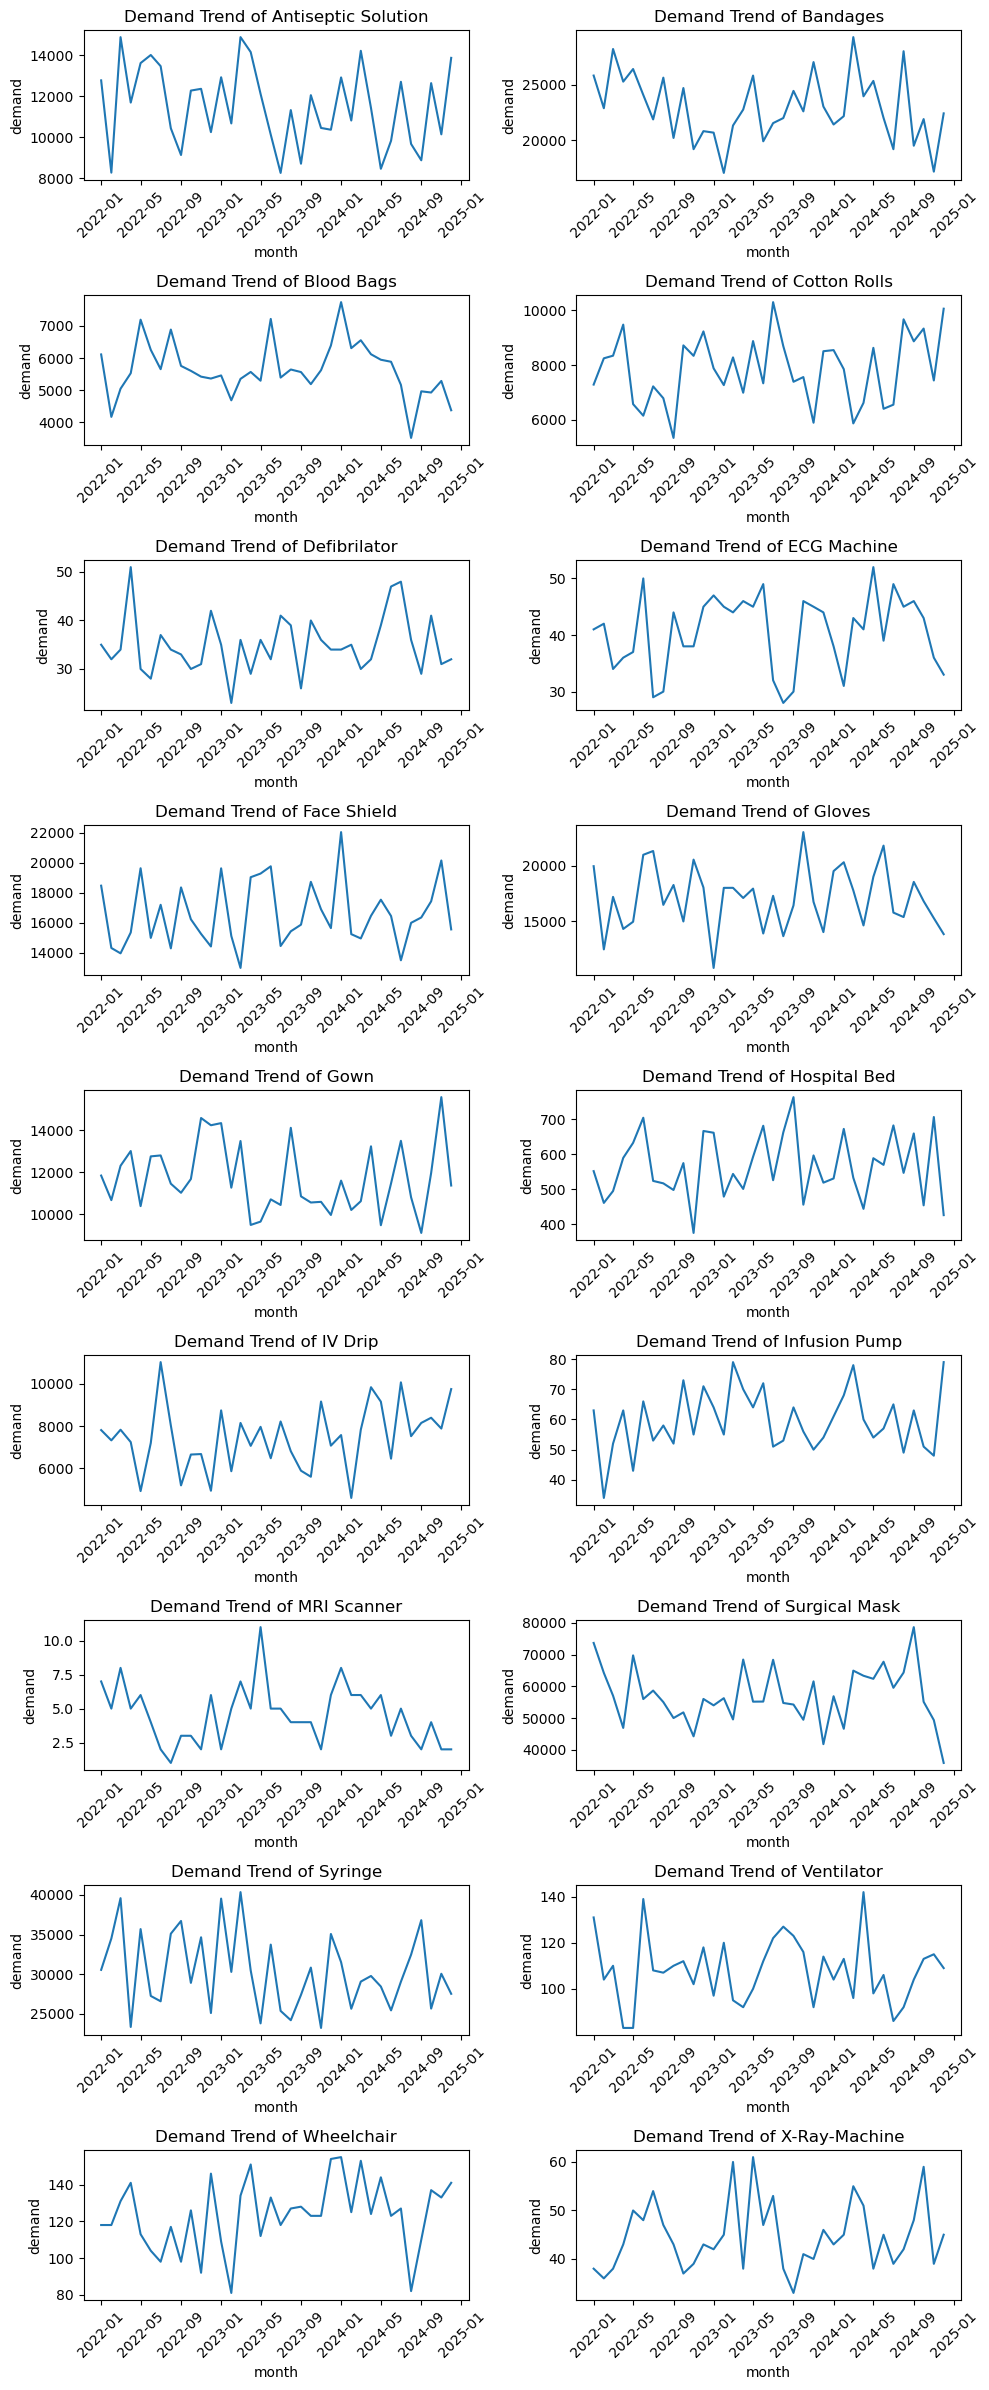

In [74]:
fig, axes = plt.subplots(int(len(restock_df_analysis['title'].unique())/2), 2, figsize=(10, 24))
row_cnt = 0
col_loop = 0

for item in restock_df1['title'].unique():
    sns.lineplot(restock_df_analysis[restock_df_analysis['title'] == f'{item}'], x='month', y='demand', ax=axes[row_cnt, col_loop])
    axes[row_cnt, col_loop].set_title(f'Demand Trend of {item}')
    axes[row_cnt, col_loop].tick_params(axis='x', rotation=45)

    if col_loop == 1:
        row_cnt += 1
    col_loop =  1 - col_loop
    
plt.tight_layout()
plt.show()

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Model Creation</h2>

<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">🎯 ADF Test</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [77]:
# Augmented Dickey-Fuller Test (ADF) --> stationarity check for the ARIMA
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print('✅ Data is stationary.')
        return True
    else:
        print('❌ Data is NOT stationary. Differencing is needed.')
        return False

<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">🎯 Model Training</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [79]:
# Categorical One-Hot Encoding
restock_df_model = restock_df1.copy()
restock_df_model = pd.get_dummies(restock_df_model, columns=['ABC_category'], prefix='ABC')
restock_df_model[['ABC_A', 'ABC_B', 'ABC_C']] = restock_df_model[['ABC_A', 'ABC_B', 'ABC_C']].astype(int)

# Numerical Feature Scaling
scaler = StandardScaler()
restock_df_model[['restock_quantity']] = scaler.fit_transform(restock_df_model[['restock_quantity']])

In [80]:
item_arima_models = {}
item_X_data = {}
item_arr = restock_df1[~restock_df1['title'].isin([])]['title'].unique()

for item in item_arr:
    item_name = item
    print(f'\n\nITEM NAME: {item_name}')
    
    X = restock_df_model[restock_df_model['title'] == f'{item_name}'][['title', 'month', 'demand', 'restock_quantity', 'ABC_A', 'ABC_B', 'ABC_C']].copy()
    X = X.set_index('month')
    X.drop('title', axis=1, inplace=True)
    
    # Data Split
    mask = (X.index < '2024-06')
    X_train = X[mask].copy()
    X_test = X[~mask].copy()
    
    # Check demand stationarity using ADF
    is_stationary = adf_test(X_train['demand'])
    
    # Perform auto_arima to find the best (p,d,q) order
    stepwise_fit = auto_arima(X_train['demand'], seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
    p, d, q = stepwise_fit.order

    if item_name == 'IV Drip':
        model = SARIMAX(X_train['demand'], 
                        order=(2, d, q),
                        seasonal_order=(1, 1, 1, 3),
                        exog=X_train[['restock_quantity', 'ABC_A', 'ABC_B', 'ABC_C']],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
    else:
        model = SARIMAX(X_train['demand'], 
                        order=(p, d, q),
                        seasonal_order=(1, 1, 1, 3),
                        exog=X_train[['restock_quantity', 'ABC_A', 'ABC_B', 'ABC_C']],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
    model_fit = model.fit()
    print(model_fit.summary())
    item_arima_models[item_name] = model_fit
    item_X_data[item_name] = [X, X_train, X_test]



ITEM NAME: Antiseptic Solution
ADF Statistic: -0.3039821259066853
p-value: 0.9249384474408775
❌ Data is NOT stationary. Differencing is needed.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=539.723, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=628.015, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=548.376, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=601.992, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=537.735, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=535.735, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=537.734, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=530.066, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=528.113, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=525.869, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : A

C:\Users\Lance Ventura\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Lance Ventura\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\Lance Ventura\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\Lance Ventura\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\Lance Ventura\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\Lance Ventura\anaconda3\Lib\site-packages\statsmodels\tsa\statespac

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=550.671, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=547.020, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=548.414, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=548.955, Time=0.03 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.016 seconds
                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                   29
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 3)   Log Likelihood                -186.065
Date:                             Tue, 25 Feb 2025   AIC                            390.130
Time:                                     20:24:41   BIC                            399.530
Sample:                                 01-31-2022   HQIC                           392.170
                                      - 05-31-2024                                         
Covariance Type:   

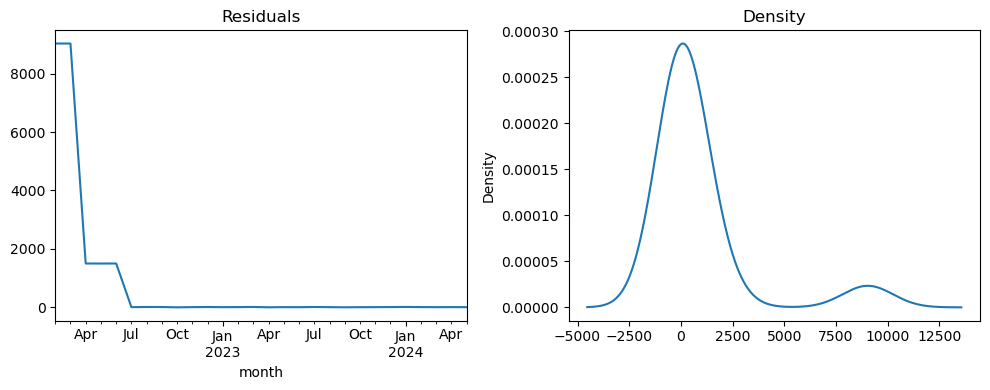

In [81]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.tight_layout()
plt.show()

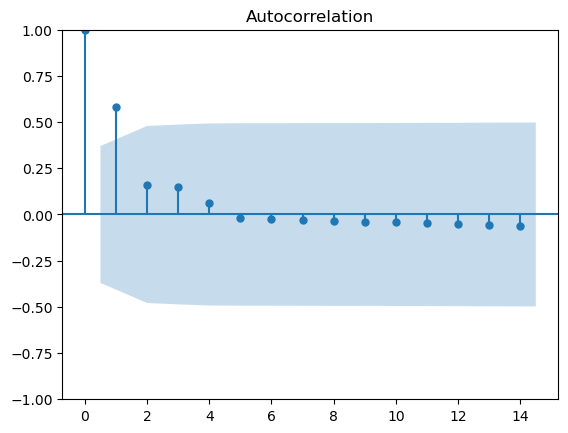

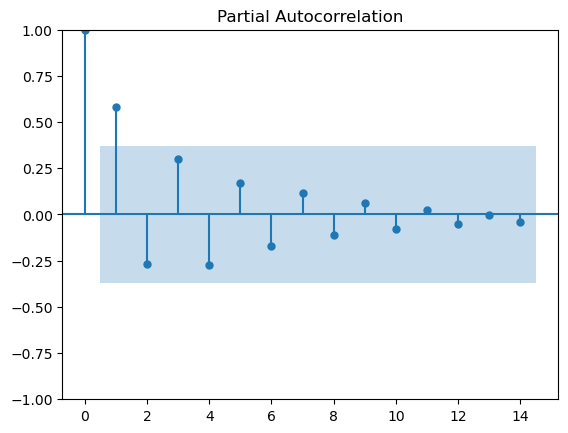

In [82]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Model Evaluation</h2>

In [84]:
# Forecast Future Demand
for item_name, model in item_arima_models.items():
    X_train = item_X_data[item_name][1]
    X_test = item_X_data[item_name][2]
    future_steps = len(X_test)
    future_exog = pd.DataFrame({
        'restock_quantity': [X_train['restock_quantity'].mean()] * future_steps,
        'ABC_A': [X_train['ABC_A'].mean()] * future_steps,
        'ABC_B': [X_train['ABC_B'].mean()] * future_steps,
        'ABC_C': [X_train['ABC_C'].mean()] * future_steps
    })
    
    forecast = model.forecast(steps=future_steps, exog=future_exog)
    print(f'ITEM NAME: {item_name}')
    print(forecast)
    item_X_data[item_name].append(forecast)

ITEM NAME: Antiseptic Solution
2024-06    11574.887088
2024-07    12073.249217
2024-08    11050.441696
2024-09    11659.704430
2024-10    12134.660064
2024-11    10880.536967
2024-12    11647.498900
Freq: M, Name: predicted_mean, dtype: float64
ITEM NAME: Bandages
2024-06    23146.931202
2024-07    23941.473676
2024-08    24008.964219
2024-09    23288.588655
2024-10    23939.991153
2024-11    23996.676564
2024-12    23274.413600
Freq: M, Name: predicted_mean, dtype: float64
ITEM NAME: Blood Bags
2024-06    5972.770308
2024-07    6765.318103
2024-08    5913.083403
2024-09    5779.475469
2024-10    6340.923518
2024-11    5728.843353
2024-12    5927.503210
Freq: M, Name: predicted_mean, dtype: float64
ITEM NAME: Cotton Rolls
2024-06    7476.893481
2024-07    7414.463622
2024-08    7687.019578
2024-09    7619.168382
2024-10    7698.649322
2024-11    7669.435649
2024-12    7663.524945
Freq: M, Name: predicted_mean, dtype: float64
ITEM NAME: Defibrilator
2024-06    34.910209
2024-07    34.95

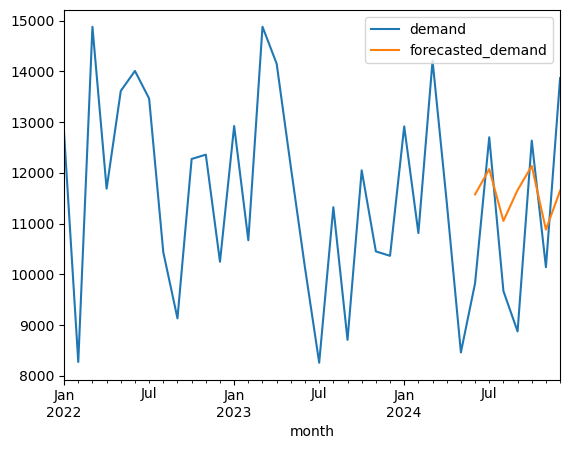

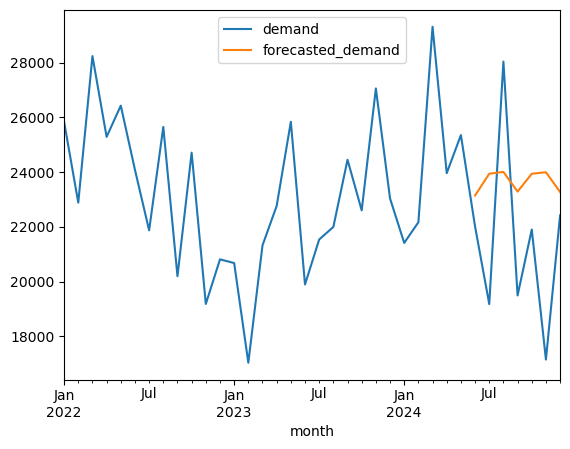

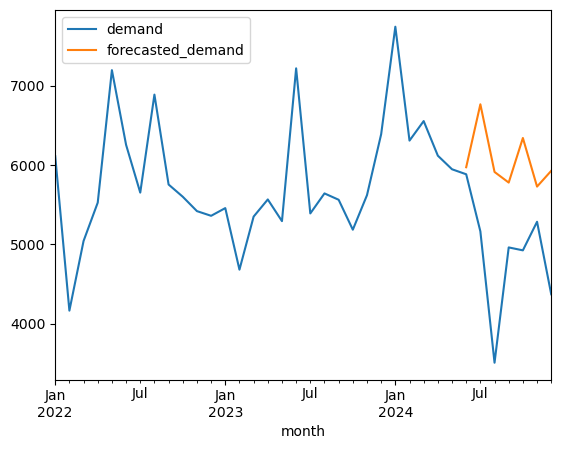

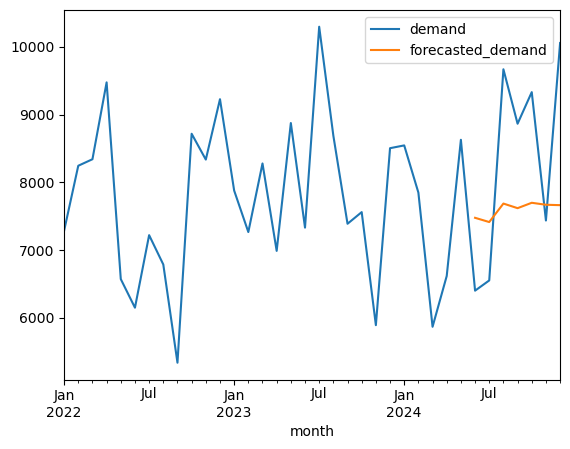

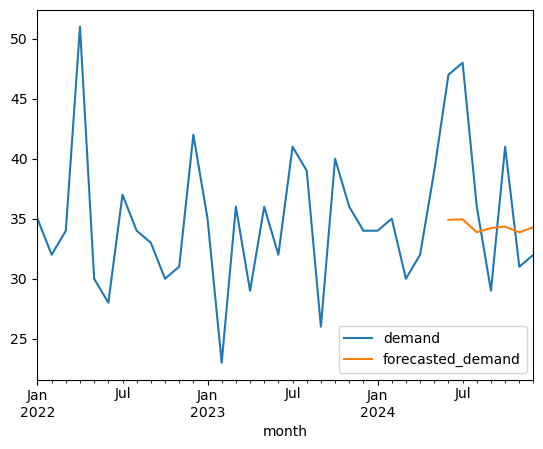

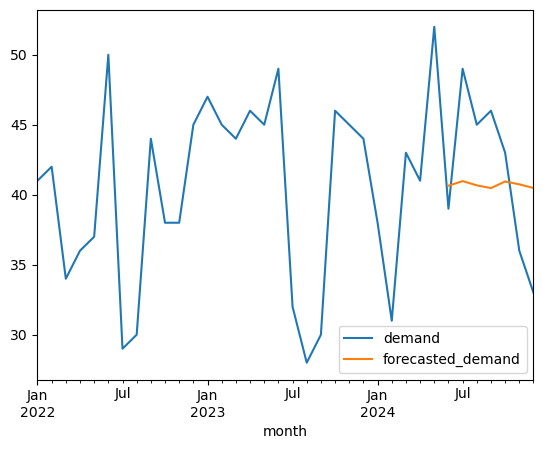

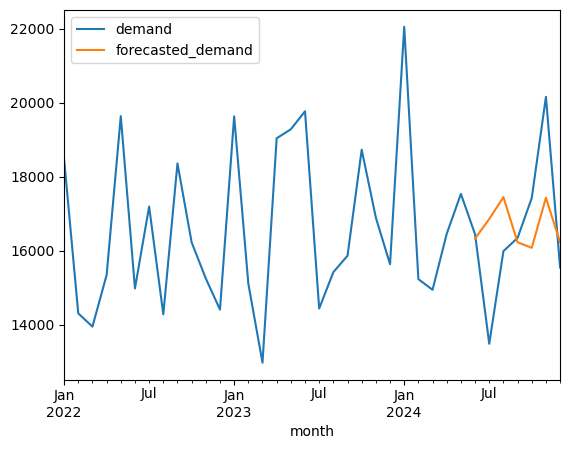

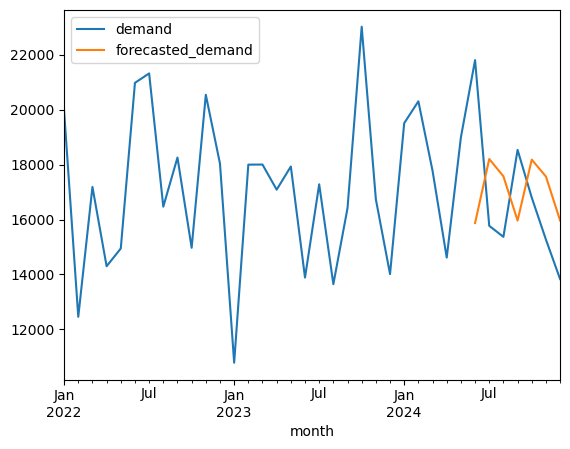

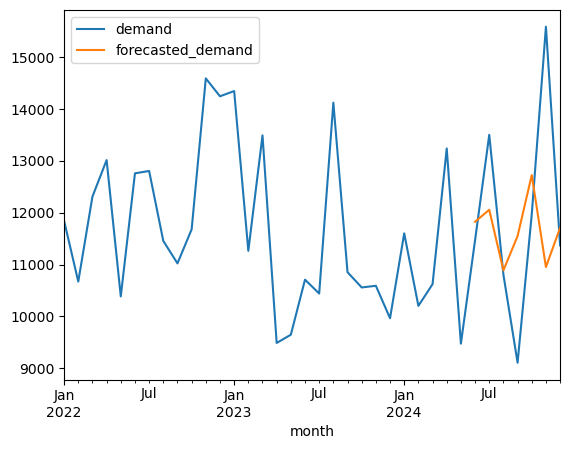

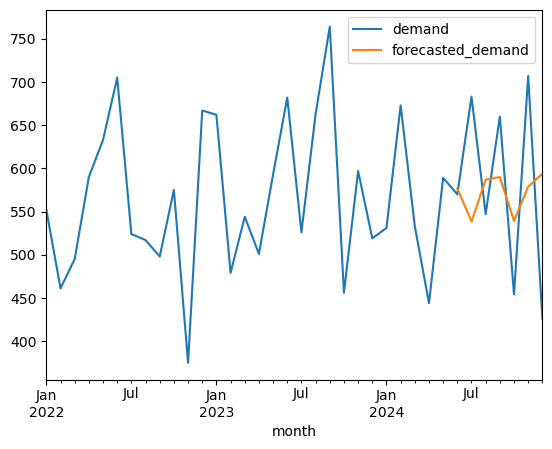

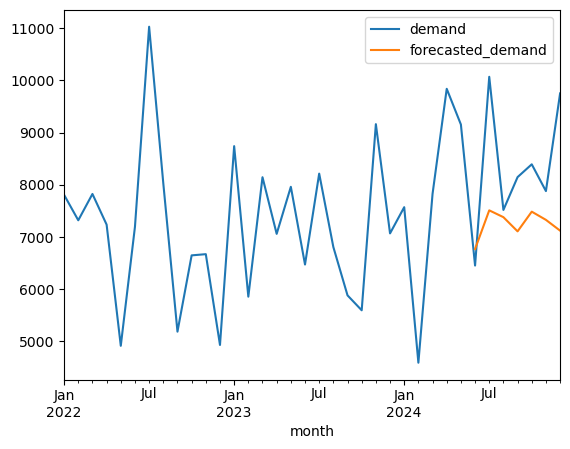

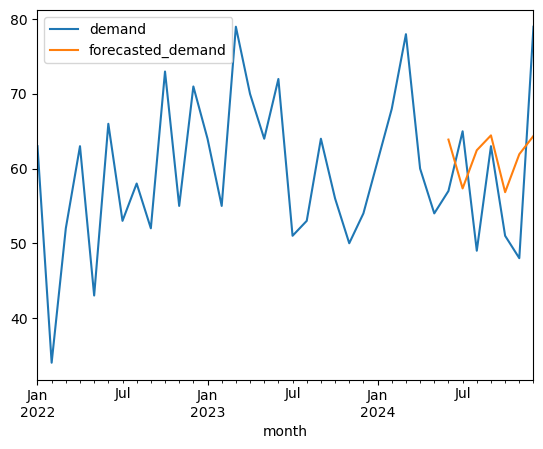

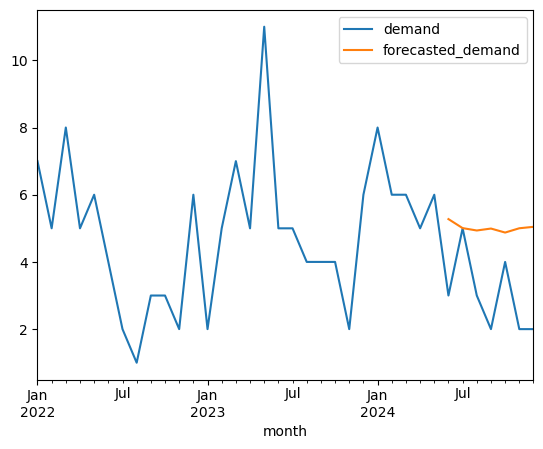

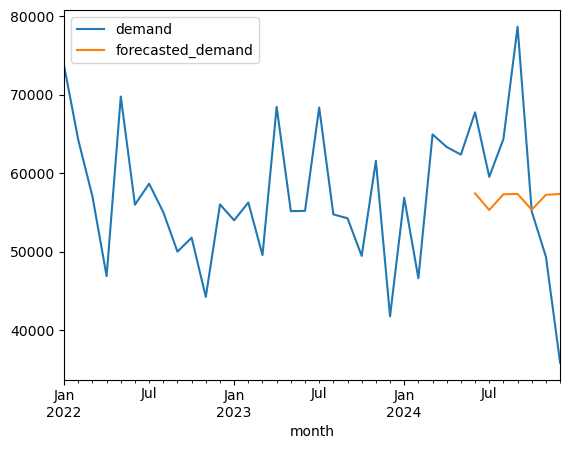

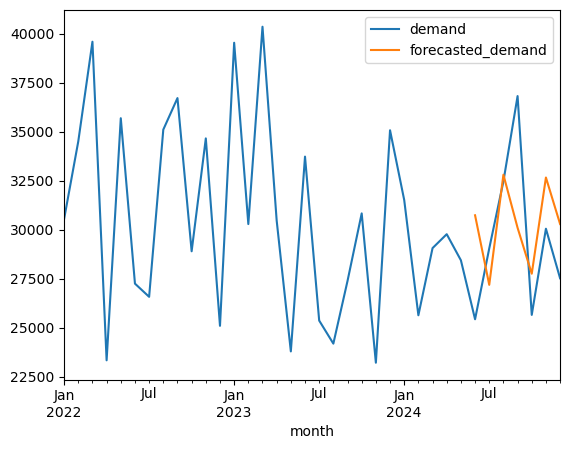

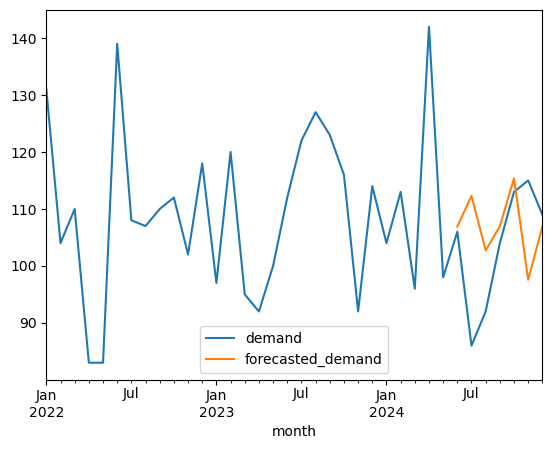

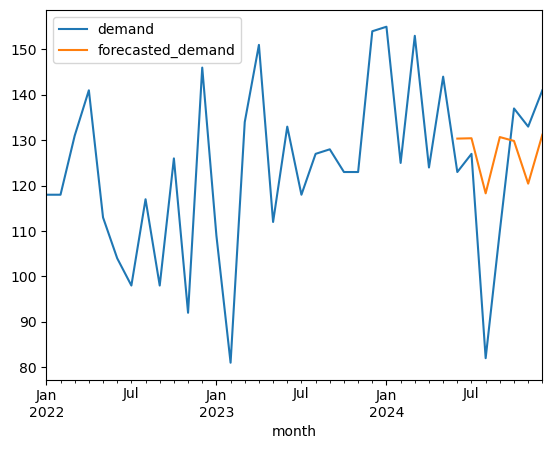

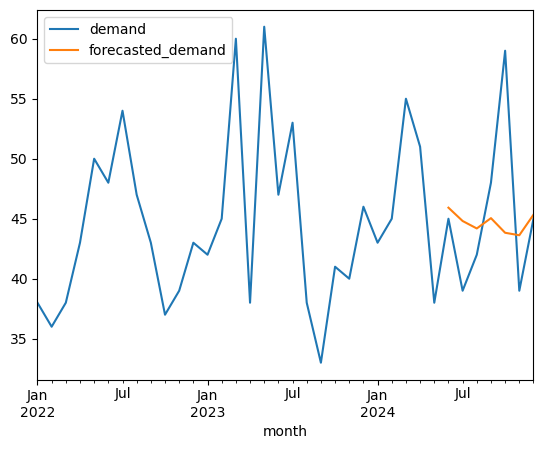

In [85]:
# Forecast Actual vs Predicted
for item_name, item_data in item_X_data.items():
    X = item_data[0]
    X_train = item_data[1]
    forecast = item_data[3]
    X['forecasted_demand'] = [None]*len(X_train) + list(forecast)
    X[['demand', 'forecasted_demand']].plot()
    plt.show()

In [86]:
def mean_absolute_percentage_error(y_actual, y_predicted):
    return np.mean(np.abs((y_actual - y_predicted) / y_actual)) * 100

for item_name, item_data in item_X_data.items():
    X_test = item_data[2]
    forecast = item_data[3]
    y_actual = X_test['demand']
    y_predicted = forecast
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
    
    # Compute MAPE
    mape = mean_absolute_percentage_error(y_actual, y_predicted)
    
    # Print Results
    print(f'ITEM NAME: {item_name}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')

ITEM NAME: Antiseptic Solution
RMSE: 1642.22
MAPE: 13.68%
ITEM NAME: Bandages
RMSE: 3897.60
MAPE: 16.69%
ITEM NAME: Blood Bags
RMSE: 1394.90
MAPE: 27.14%
ITEM NAME: Cotton Rolls
RMSE: 1503.16
MAPE: 15.56%
ITEM NAME: Defibrilator
RMSE: 7.61
MAPE: 15.63%
ITEM NAME: ECG Machine
RMSE: 5.33
MAPE: 11.84%
ITEM NAME: Face Shield
RMSE: 1823.01
MAPE: 8.74%
ITEM NAME: Gloves
RMSE: 3030.00
MAPE: 15.64%
ITEM NAME: Gown
RMSE: 2081.55
MAPE: 11.49%
ITEM NAME: Hospital Bed
RMSE: 106.43
MAPE: 16.65%
ITEM NAME: IV Drip
RMSE: 1501.29
MAPE: 12.81%
ITEM NAME: Infusion Pump
RMSE: 10.22
MAPE: 16.09%
ITEM NAME: MRI Scanner
RMSE: 2.30
MAPE: 87.76%
ITEM NAME: Surgical Mask
RMSE: 12827.20
MAPE: 19.53%
ITEM NAME: Syringe
RMSE: 3698.24
MAPE: 10.50%
ITEM NAME: Ventilator
RMSE: 12.71
MAPE: 9.30%
ITEM NAME: Wheelchair
RMSE: 17.39
MAPE: 13.34%
ITEM NAME: X-Ray-Machine
RMSE: 6.54
MAPE: 9.52%


<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Model Export</h2>

In [88]:
for item_name, model in item_arima_models.items():
    file_item_name = item_name.replace('-', ' ').split(' ')
    file_item_name = '_'.join(file_item_name)
    file_path = f'models/{file_item_name}_sarimax.joblib'
    joblib.dump(model, file_path)